#PlantCare-Mango Leaf Disease Detection



##Collecting Data

###1. Setting Up Kaggle API for Dataset Access

In [8]:
pip install -q kaggle

In [1]:
!mkdir ~/.kaggle

In [2]:
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [3]:
!chmod 600 ~/.kaggle/'kaggle.json'

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


###2. Listing and Downloading Dataset for Kaggle


In [4]:
! kaggle datasets list

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 407, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


In [5]:
!kaggle datasets download -d 'gauravduttakiit/mango-leaf-disease'

Dataset URL: https://www.kaggle.com/datasets/gauravduttakiit/mango-leaf-disease
License(s): other
 99% 102M/103M [00:00<00:00, 144MB/s] 
100% 103M/103M [00:00<00:00, 112MB/s]


###3. Extracting

In [6]:
import zipfile
import os
import shutil

In [7]:
dataset_zip = zipfile.ZipFile('mango-leaf-disease.zip','r')
dataset_zip.extractall()
dataset_zip.close()

###4. Importing Required Libraries

In [9]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, AveragePooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.applications import DenseNet121, EfficientNetB4, Xception, VGG16, VGG19

##Cleaning and Formatting Data

In [10]:
train_data = tf.keras.utils.image_dataset_from_directory(
    '/content/train',
    labels='inferred',
    label_mode='categorical',
    image_size=(256, 256),
    batch_size=32)

Found 3200 files belonging to 8 classes.


In [11]:
from tensorflow.keras import layers

preprocessing_layers = tf.keras.Sequential([
    layers.Rescaling(1./255),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

In [12]:
train_data = train_data.map(lambda x, y: (preprocessing_layers(x), y))

##Dataset Preparation: Training, Validation, and Evaluation

In [13]:
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/test',
    labels='inferred',
    label_mode='categorical',
    image_size=(256, 256),
    batch_size=32)

Found 800 files belonging to 8 classes.


In [14]:
val_data = val_data.map(lambda x, y: (preprocessing_layers(x), y))

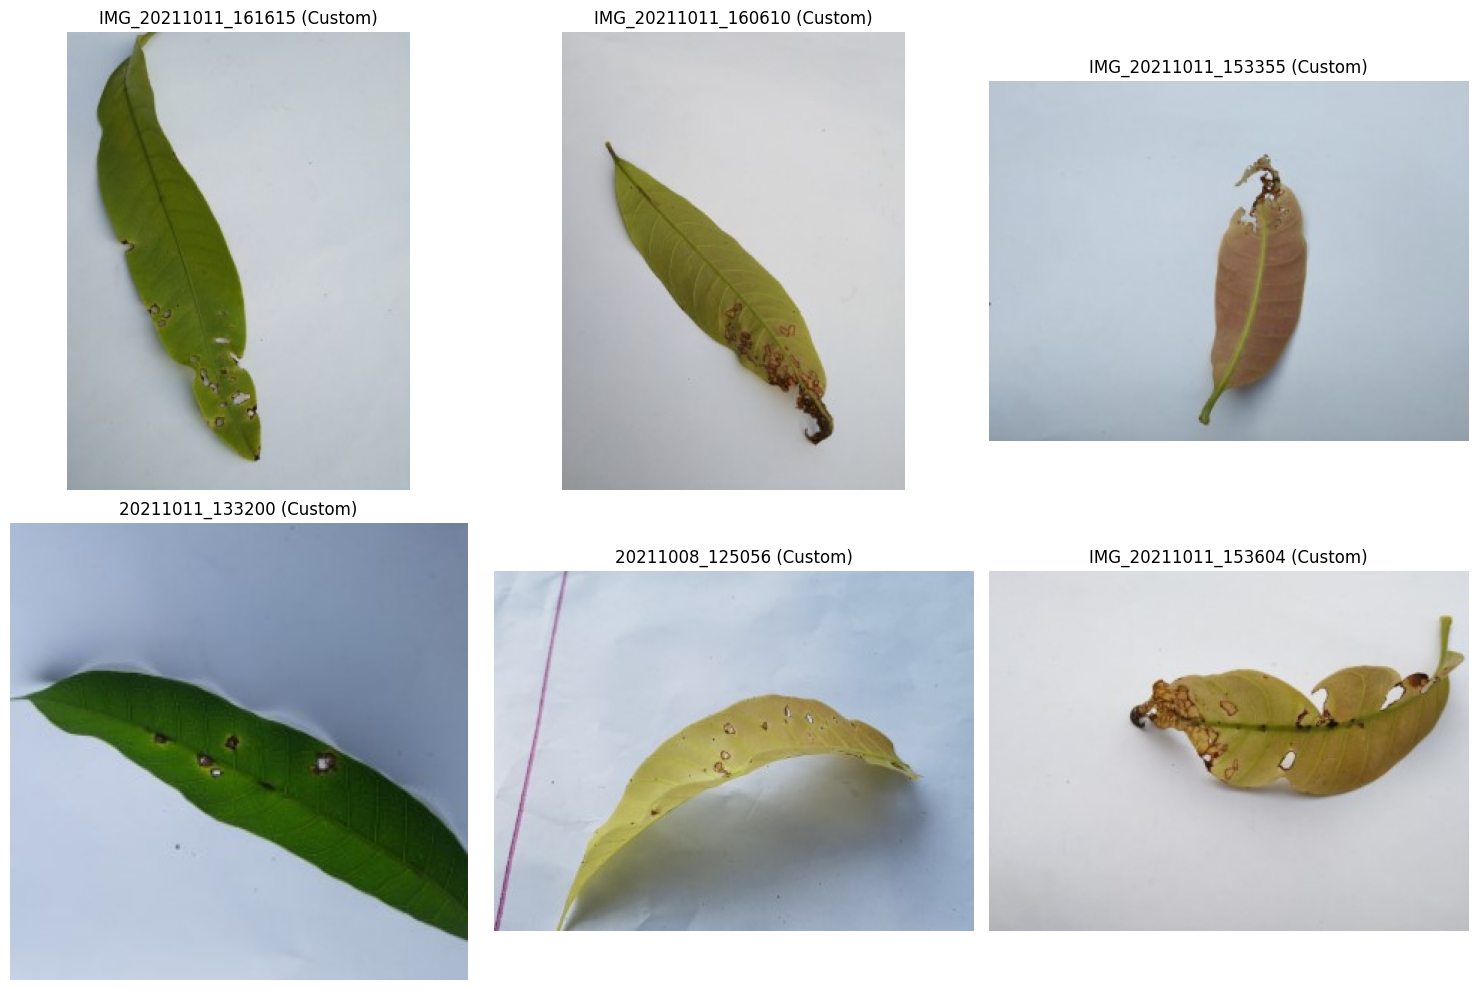

In [15]:
path = "/content/train/Anthracnose"

image_files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i in range(6):
    image_file = image_files[i]
    label = image_file.split('.')[0]

    img_path = os.path.join(path, image_file)
    img = mpimg.imread(img_path)
    ax = axs[i // 3, i % 3]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(label)

plt.tight_layout()
plt.show()

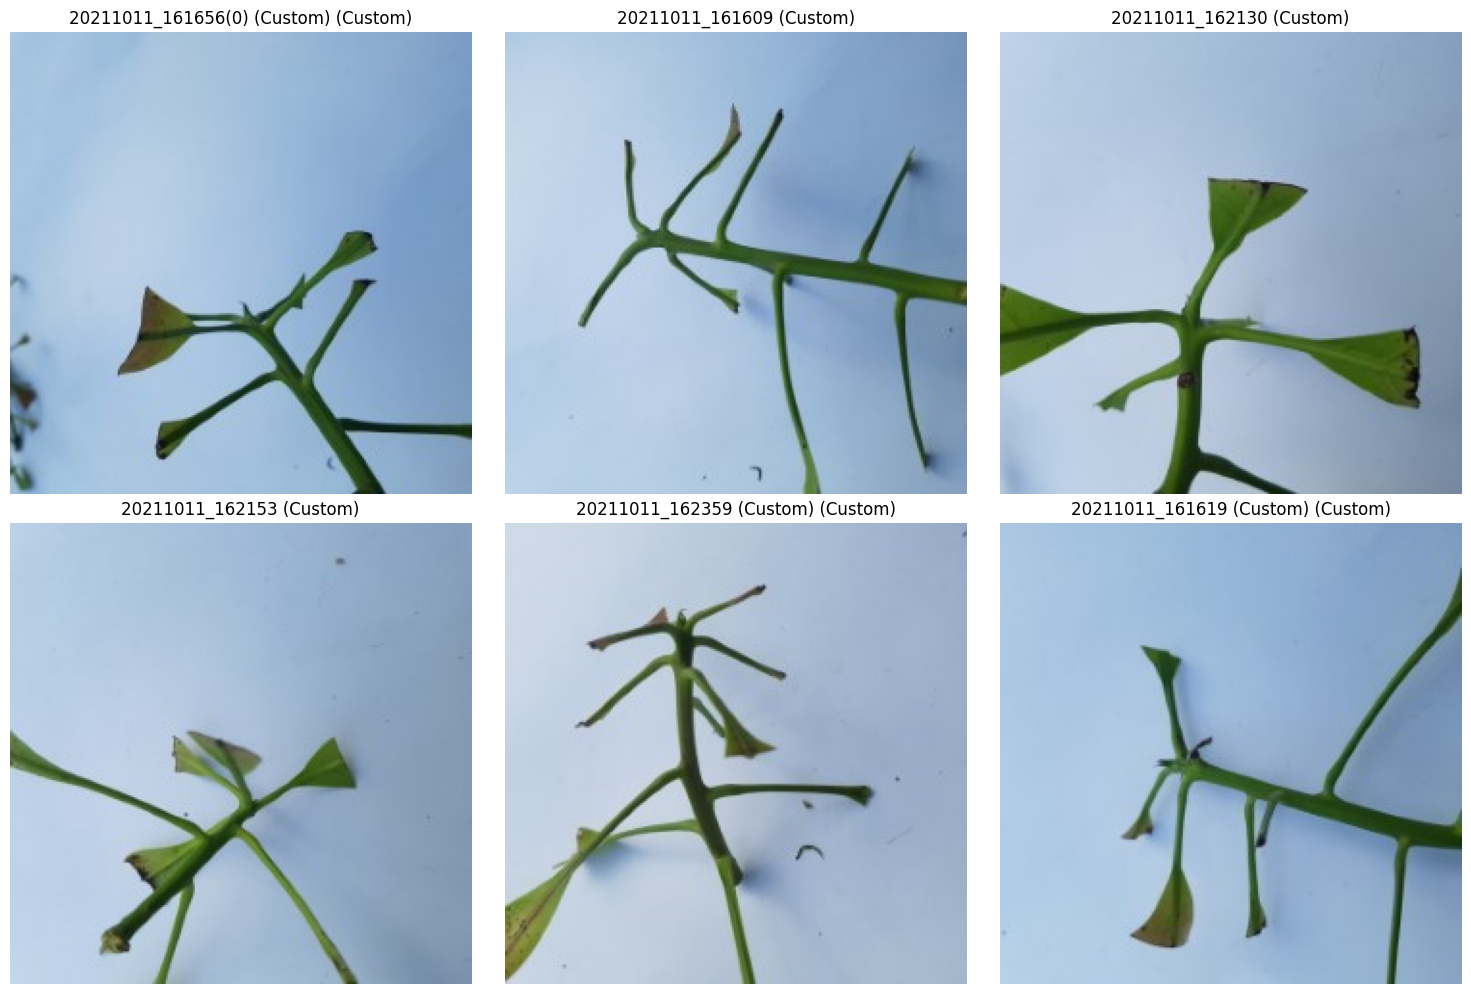

In [16]:
# Path to the directory containing images
path = "/content/test/Cutting Weevil"

# Get a list of all image file names in the directory
image_files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

# Display the first 6 images with their labels
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i in range(6):
    # Get the image file name and its label
    image_file = image_files[i]
    label = image_file.split('.')[0]

    # Load and display the image
    img_path = os.path.join(path, image_file)
    img = mpimg.imread(img_path)
    ax = axs[i // 3, i % 3]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(label)

plt.tight_layout()
plt.show()

In [17]:
conv_base = DenseNet121(
    weights='imagenet',
    include_top = False,
    input_shape=(256,256,3),
    pooling='avg'
)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
conv_base.trainable = True

for layer in conv_base.layers[:121]:
    layer.trainable = False

In [19]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(256, 256, 3)),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(8, activation='softmax')
])

In [20]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

##Model Training and Evaluation

In [21]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') is not None and logs.get('val_accuracy') >= 0.95:
            print("\nReached 95% validation accuracy, so cancelling training!")
            self.model.stop_training = True

callbacks = MyCallback()

In [22]:
history = model.fit(
    train_data,
    epochs=50,
    validation_data=val_data,
    callbacks=[callbacks]
)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 279s 3s/step - accuracy: 0.2365 - loss: 1.9536 - val_accuracy: 0.3887 - val_loss: 1.5157
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 336s 3s/step - accuracy: 0.4764 - loss: 1.3712 - val_accuracy: 0.6212 - val_loss: 1.0901
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 318s 3s/step - accuracy: 0.6477 - loss: 1.0210 - val_accuracy: 0.6750 - val_loss: 0.9007
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 311s 3s/step - accuracy: 0.6802 - loss: 0.8426 - val_accuracy: 0.7613 - val_loss: 0.6756
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 273s 3s/step - accuracy: 0.7455 - loss: 0.7180 - val_accuracy: 0.7450 - val_loss: 0.6509
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 320s 3s/step - accuracy: 0.7827 - loss: 0.6090 - val_accuracy: 0.7750 - val_loss: 0.5939
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 273s 3s/step - accuracy: 0.7815 - loss: 0.5838 - val_accuracy: 0.7925 - val_loss: 0.5046
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 276s 3s/step - accuracy: 0.8218 - loss: 0.4842 - val_accu

In [27]:
evaluation = model.evaluate(val_data)

print("Validation Loss:", evaluation[0])
print("Validation Accuracy:", evaluation[1])

25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9361 - loss: 0.1597
Validation Loss: 0.14534232020378113
Validation Accuracy: 0.9474999904632568


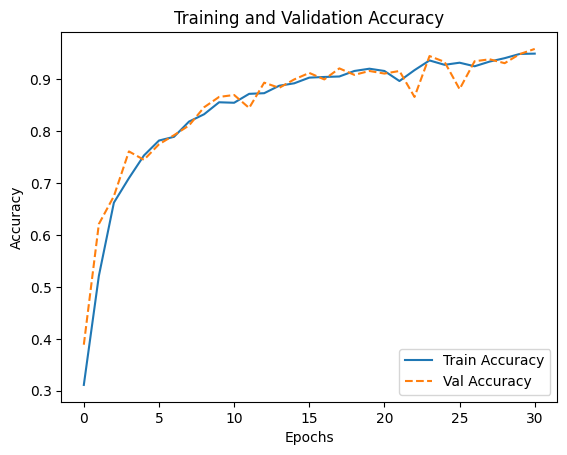

In [30]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', linestyle='--')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()



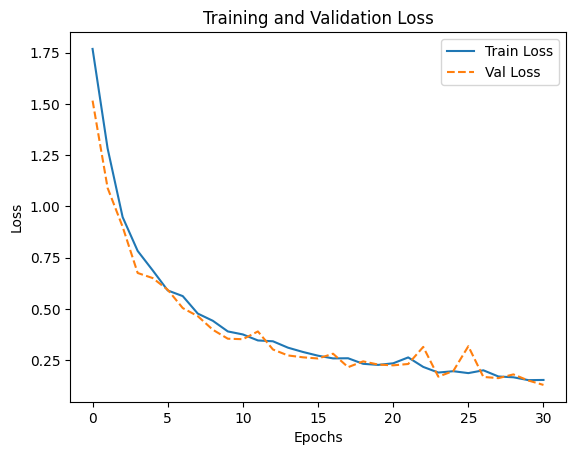

In [31]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [32]:
from ipywidgets import widgets
from io import BytesIO
import numpy as np
rescale_layer = tf.keras.layers.Rescaling(1./255)

uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)
out = widgets.Output()
display(out)

def file_predict(filename, file, out):
    """ A function for creating the prediction and printing the output."""

    image = tf.keras.utils.load_img(file, target_size=(256, 256))
    image = tf.keras.utils.img_to_array(image)
    image = rescale_layer(image)
    image = np.expand_dims(image, axis=0)


    prediction = model.predict(image, verbose=0)


    class_names = ['Anthracnose', 'Bacterial Canker', 'Cutting Weevil', 'Die Back',
                   'Gall Midge', 'Healthy', 'Powdery Mildew','Sooty Mould']


    predicted_class = np.argmax(prediction)

    with out:
        print(f"{filename} termasuk dalam kelas '{class_names[predicted_class]}' dengan probabilitas {prediction[0][predicted_class]:.2f}")

    for i, class_name in enumerate(class_names):
        print(f"Probabilitas untuk {class_name}: {prediction[0][i]:.4f}")


def on_upload_change(change):
    """ A function for getting files from the widget and running the prediction."""
    items = change.new
    for filename, file_data in items.items():
        file_jpgdata = BytesIO(file_data['content'])
        file_predict(filename, file_jpgdata, out)

uploader.observe(on_upload_change, names='value')

FileUpload(value={}, accept='image/*', description='Upload', multiple=True)

Output()

##Save the model

In [36]:
model.save('Mango_leaf_model.keras')

In [37]:
model.save('mango_plant_care.h5')

In [38]:
from google.colab import files
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array

model = load_model('/content/mango_plant_care.h5')

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           4,104 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,281,706 (4.89 MB)

 Trainable params: 1,281,704 (4.89 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

##Deploy to TFlite

In [39]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()

Saved artifact at '/tmp/tmpatumjd0a'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  133648144370144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133648144375072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133648144436032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133648144439552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133648144448352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133648144449056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133648144572384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133648144570448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133648144580304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133648144577840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1336481447672

In [40]:
tflite_name = 'tf_lite_model_mango.tflite'

with open(tflite_name, 'wb') as f:
  f.write(tflite_model)